In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [19]:
energy = pd.read_csv('https://raw.githubusercontent.com/cjfghk5697/forecastsolar/main/csv%20file/energy.csv')
dangjin_fcst = pd.read_csv('https://raw.githubusercontent.com/cjfghk5697/forecastsolar/main/csv%20file/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('https://raw.githubusercontent.com/cjfghk5697/forecastsolar/main/csv%20file/ulsan_fcst_data.csv')

In [33]:
#날짜 데이터로 변환
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

In [34]:
#예측 데이터 중 14시 데이터 가져옴
dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14]
ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==14]

In [35]:
#예측시간이 10~33시 가져옴
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=10)&(dangjin_fcst_14['forecast']<=33)]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=10)&(ulsan_fcst_14['forecast']<=33)]

In [36]:
#시간 더함.
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date)
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1111: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [37]:
dangjin_fcst_14.head(10)


,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,-2.0,55.0,6.7,336.0,1.0,2018-03-02 00:00:00
23,2018-03-01 14:00:00,13.0,-4.0,55.0,5.5,339.0,1.0,2018-03-02 03:00:00
24,2018-03-01 14:00:00,16.0,-5.0,60.0,4.3,344.0,1.0,2018-03-02 06:00:00
25,2018-03-01 14:00:00,19.0,-2.0,55.0,2.0,345.0,1.0,2018-03-02 09:00:00
26,2018-03-01 14:00:00,22.0,1.0,45.0,0.8,256.0,1.0,2018-03-02 12:00:00
27,2018-03-01 14:00:00,25.0,3.0,50.0,2.3,270.0,1.0,2018-03-02 15:00:00
28,2018-03-01 14:00:00,28.0,1.0,55.0,1.9,264.0,1.0,2018-03-02 18:00:00
29,2018-03-01 14:00:00,31.0,-1.0,70.0,1.6,68.0,1.0,2018-03-02 21:00:00
170,2018-03-02 14:00:00,10.0,-2.0,80.0,2.4,90.0,2.0,2018-03-03 00:00:00
171,2018-03-02 14:00:00,13.0,-2.0,75.0,2.9,125.0,2.0,2018-03-03 03:00:00


In [38]:
#열 바꿈 forcast time 열을 forcast_time으로 바꿈
dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [39]:
dangjin_fcst_14.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
22,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
23,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
24,2018-03-02 06:00:00,-5.0,60.0,4.3,344.0,1.0
25,2018-03-02 09:00:00,-2.0,55.0,2.0,345.0,1.0
26,2018-03-02 12:00:00,1.0,45.0,0.8,256.0,1.0


In [40]:
#주기 3시간에서 1시간 단위로 생성
dangjin_fcst_14_ = pd.DataFrame()
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [41]:
#그냥 다 붙임
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer')
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

In [42]:
dangjin_fcst_14_.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN


In [43]:
#선형보간 nan값 넣음선형보간 nan값 넣음
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()

In [44]:
dangjin_fcst.head()


,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0


In [45]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [46]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    # 24번째 행부터 가져옴 그리고 열의 순서로 인덱스 설정
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    # 모든 행 가져옴 그리고 열의 순서로 인덱스 설정
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    #axis=1로 옆으로 합치기.
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    #시간, 날짜 띄기
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    # 열 가져옴 train, test 나눠서 가져옴
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    
    train_df = train_df[train_df[target]!=0]

    # 행 가져오는   val_df = feature_df.iloc[-24*30:]    
    # 발전량이 0인 데이터를 제외            
    train_df = train_df[train_df[target]!=0]
    
    # 행 가져오고 ndarray 형식으로 바꿈 하루치가 하나의 괄호로 묶임.
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
                                    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    return train_x, train_y, val_x, val_y

In [47]:
#mae 평균절대오차 가져오기

def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [48]:
#mae 평균절대오차 가져오기
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [49]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [109]:
#train,test 데이터셋 나누기
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
#왜 1000인가 그리고 10000은 학습횟수 feval 평가 기준 verbose 터미널에 보여지나 그거 
#1200 6.85 1400 5.8 1800 4.43 2000 4.41
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 9
[LightGBM] [Info] Start training from score 247.345048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's l1: 55.5103	valid_0's score: 8.19728


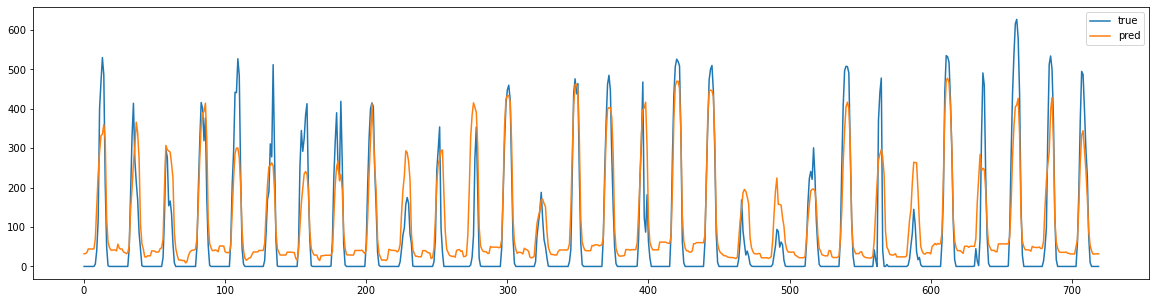

CV Score :  8.197275967964854


In [110]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
#그래프 범례
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [111]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
#4000 2.4
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 11949, number of used features: 9
[LightGBM] [Info] Start training from score 193.765671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]	valid_0's l1: 43.1937	valid_0's score: 9.64923


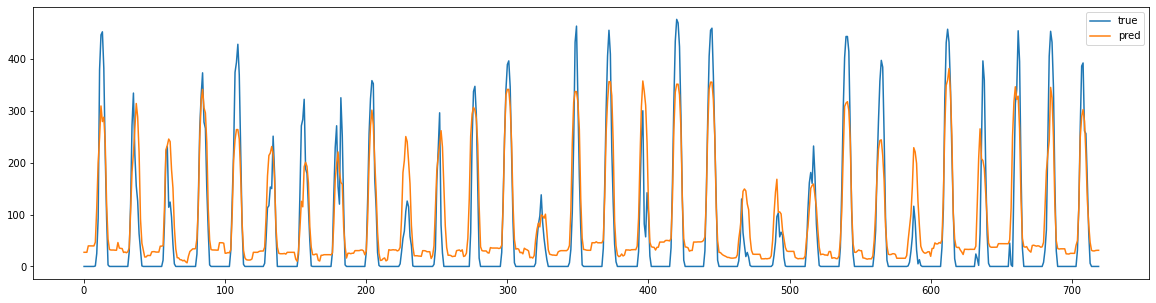

CV Score :  9.64922890871354


In [112]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))


In [113]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 11349, number of used features: 9
[LightGBM] [Info] Start training from score 308.414486
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 51.4266	valid_0's score: 9.93317
Early stopping, best iteration is:
[439]	valid_0's l1: 56.7378	valid_0's score: 9.83863


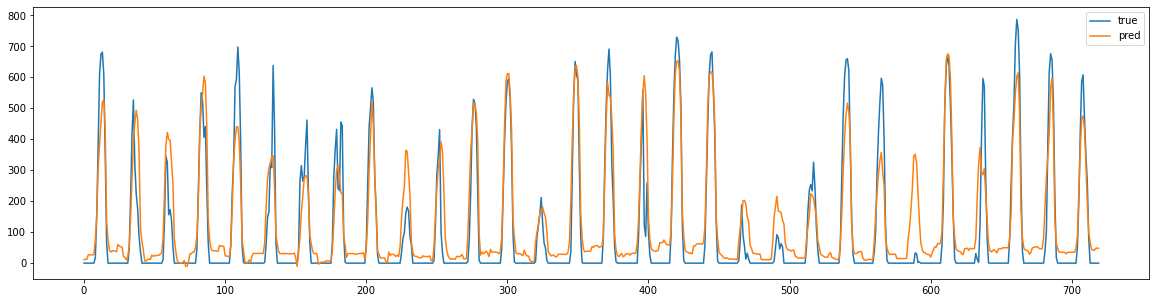

CV Score :  9.83862629223579


In [114]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [108]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500 
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 17.2554	valid_0's score: 6.35312
Early stopping, best iteration is:
[648]	valid_0's l1: 14.5273	valid_0's score: 6.32597


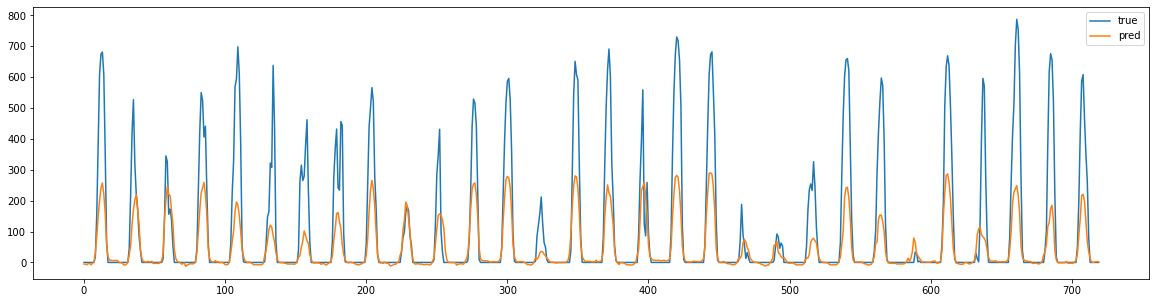

CV Score :  24.473054510134457


In [117]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [120]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [121]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)


In [122]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

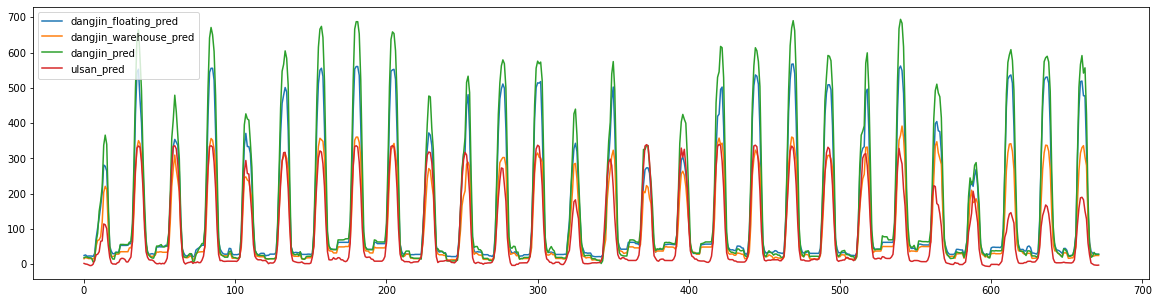

In [123]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()


In [124]:
submission = pd.read_csv('https://raw.githubusercontent.com/cjfghk5697/forecastsolar/main/csv%20file/sample_submission.csv')


In [125]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [126]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,24.483832,15.214285,18.105945,1.873168
1,2021-02-01 02:00:00,25.977351,18.773044,20.342899,0.174000
2,2021-02-01 03:00:00,22.270540,17.017413,20.039962,-0.375374
3,2021-02-01 04:00:00,22.867442,15.654681,17.890137,-2.402164
4,2021-02-01 05:00:00,22.867442,15.654681,17.890137,-4.250874
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [127]:
submission.to_csv('dacon_baseline_1.csv', index=False)